In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import pandas as pd



In [ ]:
class Node:
    def __init__(self, x, y, number):
        self.x = x
        self.y = y
        self.number = number
        self.neighbors = []

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def get_coordinates(self):
        return self.x, self.y
    
    def __repr__(self):
        return f"Node {self.number} at ({self.x}, {self.y})"

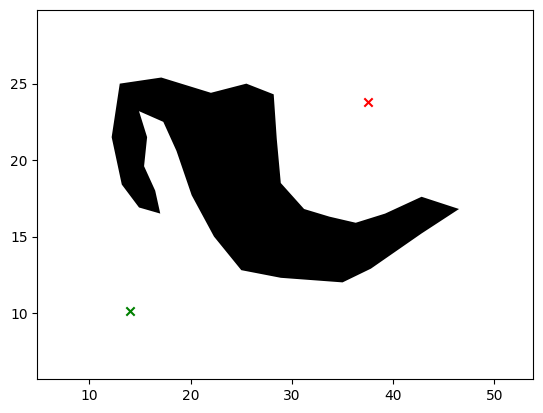

[Node 0 at (14.0, 10.1), Node 1 at (17.0, 16.5), Node 2 at (14.9, 16.9), Node 3 at (13.2, 18.4), Node 4 at (12.2, 21.5), Node 5 at (13.0, 25.0), Node 6 at (17.1, 25.4), Node 7 at (22.0, 24.4), Node 8 at (25.5, 25.0), Node 9 at (28.2, 24.3), Node 10 at (28.5, 21.4), Node 11 at (28.9, 18.5), Node 12 at (31.2, 16.8), Node 13 at (33.7, 16.3), Node 14 at (36.3, 15.9), Node 15 at (39.2, 16.5), Node 16 at (42.8, 17.6), Node 17 at (46.5, 16.8), Node 18 at (42.8, 15.2), Node 19 at (37.8, 12.9), Node 20 at (35.0, 12.0), Node 21 at (28.9, 12.3), Node 22 at (25.0, 12.8), Node 23 at (22.3, 15.0), Node 24 at (20.1, 17.7), Node 25 at (18.6, 20.6), Node 26 at (17.3, 22.5), Node 27 at (14.9, 23.2), Node 28 at (15.7, 21.5), Node 29 at (15.4, 19.6), Node 30 at (16.5, 18.0), Node 31 at (37.5, 23.8)]


In [62]:
env = "mx"
vertices = pd.read_csv("env_"+env+".csv")
first_column_data = vertices[vertices.columns[0]]
a = []
polygons = []
nodes = []
pol_number = 0
node_number = 0
xs, ys = vertices[vertices.columns[1]][0], vertices[vertices.columns[2]][0] 

for i in range (len(first_column_data)):
    x,y = vertices[vertices.columns[1]][i], vertices[vertices.columns[2]][i] 
    nodes.append(Node(x,y,node_number))
    node_number += 1
    if pol_number != vertices[vertices.columns[0]][i]:
        polygons.append(a)
        pol_number = vertices[vertices.columns[0]][i]
        a = []
    a.append([x,y])

xg, yg = x,y
polygons.append([xg,yg])

fig,ax = plt.subplots()

for i in range(1, len(polygons)-1):
    ax.add_patch(matplotlib.patches.Polygon(polygons[i], facecolor = 'k'))

min_x = min(vertices[vertices.columns[1]])
max_x = max(vertices[vertices.columns[1]])
min_y = min(vertices[vertices.columns[2]])
max_y = max(vertices[vertices.columns[2]])

mean_x = (min_x + max_x)/8
mean_y = (min_y + max_y)/8

ax.scatter(xs,ys, marker = "x", c="g")
ax.scatter(xg,yg, marker = "x", c="r")
ax.set_xlim([min_x - mean_x, max_x + mean_x])
ax.set_ylim([min_y - mean_y, max_y + mean_y])
plt.show()

print (nodes)


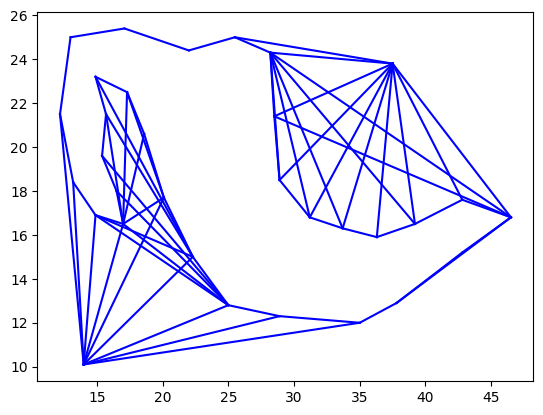

In [39]:
lines = pd.read_csv("visibility_graph_env_"+env+".csv")
connections = []

first_column_data = lines[lines.columns[0]]

for i in range (len(first_column_data)):
    x1,y1 = lines[lines.columns[0]][i], lines[lines.columns[1]][i]
    connectionsx = [vertices[vertices.columns[1]][x1], vertices[vertices.columns[1]][y1]]
    connectionsy = [vertices[vertices.columns[2]][x1], vertices[vertices.columns[2]][y1]]
    plt.plot(connectionsx, connectionsy, c = 'b')
plt.show()